Load Required Packages

In [3]:
library(dplyr)
library(ggplot2)
library(reshape2)
library(caret)
library(e1071)
library(caTools)
library(ISLR)

In [4]:
# Read in Data
paysim <- read.csv("C:/Users/jared.mcculloch/Desktop/AI Groundwork/PS_20174392719_1491204439457_withNulls_log.csv")
paysim <- paysim[1:100000,]
head(paysim)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1,PAYMENT,9839.64,C1231006815,NA,NA,M1979787155,0,0,0,0
1,PAYMENT,1864.28,C1666544295,NA,NA,M2044282225,0,0,0,0
1,TRANSFER,181.00,C1305486145,181,0,C553264065,0,0,1,0
1,CASH_OUT,181.00,C840083671,181,0,C38997010,21182,0,1,0
1,PAYMENT,11668.14,C2048537720,NA,NA,M1230701703,0,0,0,0
1,PAYMENT,7817.71,C90045638,NA,NA,M573487274,0,0,0,0


In [5]:
# Identify primary key
total_size = (length(paysim[[1]]))
print(c("total size of data set: ", total_size))
print(c("variables: ", colnames(paysim)))

[1] "total size of data set: " "100000"                  
 [1] "variables: "    "step"           "type"           "amount"        
 [5] "nameOrig"       "oldbalanceOrg"  "newbalanceOrig" "nameDest"      
 [9] "oldbalanceDest" "newbalanceDest" "isFraud"        "isFlaggedFraud"


In [6]:
# Check data types
sapply(paysim, class)

summary(paysim)

step           type         amount       nameOrig  oldbalanceOrg 
     "integer"       "factor"      "numeric"       "factor"      "numeric" 
newbalanceOrig       nameDest oldbalanceDest newbalanceDest        isFraud 
     "numeric"       "factor"      "numeric"      "numeric"      "integer" 
isFlaggedFraud 
     "integer"

      step            type           amount                nameOrig    
 Min.   : 1.0   CASH_IN :20185   Min.   :       0   C1000037689:    1  
 1st Qu.: 8.0   CASH_OUT:30718   1st Qu.:    9964   C1000039823:    1  
 Median : 9.0   DEBIT   :  988   Median :   52746   C1000079132:    1  
 Mean   : 8.5   PAYMENT :39512   Mean   :  173602   C1000109302:    1  
 3rd Qu.:10.0   TRANSFER: 8597   3rd Qu.:  211763   C1000119377:    1  
 Max.   :10.0                    Max.   :10000000   C1000148923:    1  
                                                    (Other)    :99994  
 oldbalanceOrg      newbalanceOrig            nameDest     oldbalanceDest    
 Min.   :       0   Min.   :       0   C985934102 :   78   Min.   :       0  
 1st Qu.:       0   1st Qu.:       0   C1286084959:   72   1st Qu.:       0  
 Median :   20058   Median :       0   C248609774 :   71   Median :   20839  
 Mean   :  877797   Mean   :  894102   C1590550415:   69   Mean   :  880505  
 3rd Qu.:  190264   3rd Qu.:  2148

In [7]:
# Check the character data types
print(c("What values are in the type variable? ", unique(paysim$type)))
print(c("What values are in the isFraud? ", unique(paysim$isFraud)))
print(c("What values are in the isFlaggedFraud? ", unique(paysim$isFlaggedFraud)))

[1] "What values are in the type variable? "
[2] "4"                                     
[3] "5"                                     
[4] "2"                                     
[5] "3"                                     
[6] "1"                                     
[1] "What values are in the isFraud? " "0"                               
[3] "1"                               
[1] "What values are in the isFlaggedFraud? "
[2] "0"                                      


In [8]:
# Check for missing values
any(is.na(paysim))

paysim <- na.omit(paysim)

any(is.na(paysim))

[1] TRUE

[1] FALSE

In [9]:
# Create binary from categorical type variable
paysim2 <- paysim
paysim3 <- paysim$type

TRANSFER <- gsub("TRANSFER",1,as.character(paysim3))
TRANSFER <- gsub("(PAYMENT)|(CASH_OUT)|(DEBIT)|(CASH_IN)",0,TRANSFER)
paysim2 <- cbind(paysim2,TRANSFER)

PAYMENT <- gsub("PAYMENT",1,as.character(paysim3))
PAYMENT <- gsub("(TRANSFER)|(CASH_OUT)|(DEBIT)|(CASH_IN)",0,PAYMENT)
paysim2 <- cbind(paysim2,PAYMENT)

CASH_OUT <- gsub("CASH_OUT",1,as.character(paysim3))
CASH_OUT <- gsub("(TRANSFER)|(PAYMENT)|(DEBIT)|(CASH_IN)",0,CASH_OUT)
paysim2 <- cbind(paysim2,CASH_OUT)

DEBIT <- gsub("DEBIT",1,as.character(paysim3))
DEBIT <- gsub("(TRANSFER)|(PAYMENT)|(CASH_OUT)|(CASH_IN)",0,DEBIT)
paysim2 <- cbind(paysim2,DEBIT)

CASH_IN <- gsub("CASH_IN",1,as.character(paysim3))
CASH_IN <- gsub("(TRANSFER)|(PAYMENT)|(CASH_OUT)|(DEBIT)",0,CASH_IN)
paysim2 <- cbind(paysim2,CASH_IN)

paysim <- paysim2

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0     9967    52760   173611   211784 10000000 

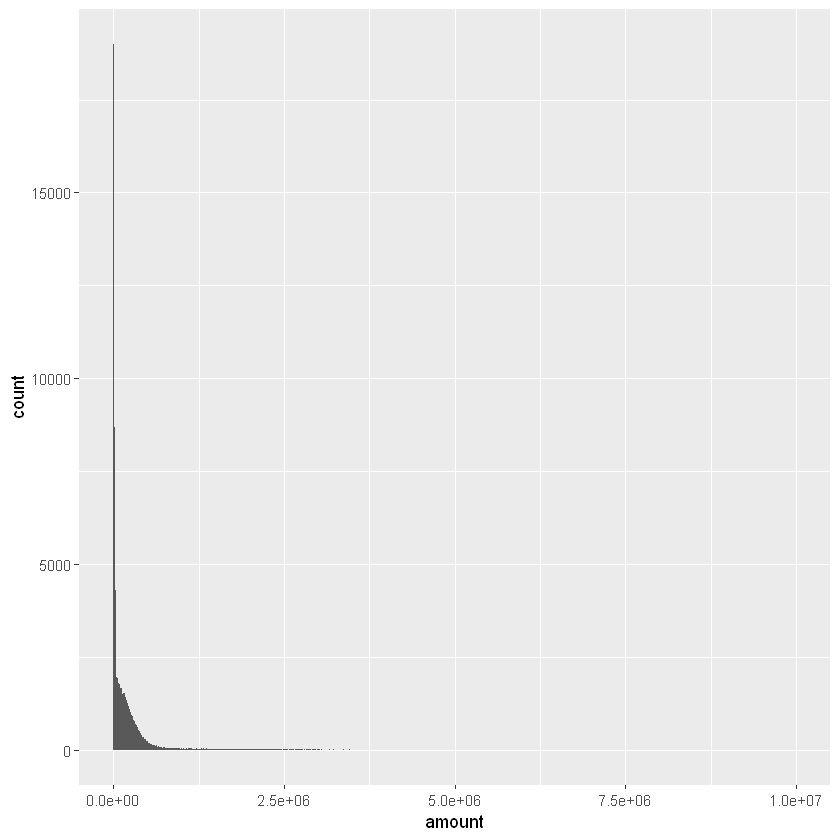

In [10]:
# Let's review one varaible before setting up the rest of the histograms
# Based on the results, we may need to tune the parameters to fit the data
summary(paysim$amount)

ggplot(paysim, aes(amount)) + geom_histogram(bins = 20, binwidth = 10000)

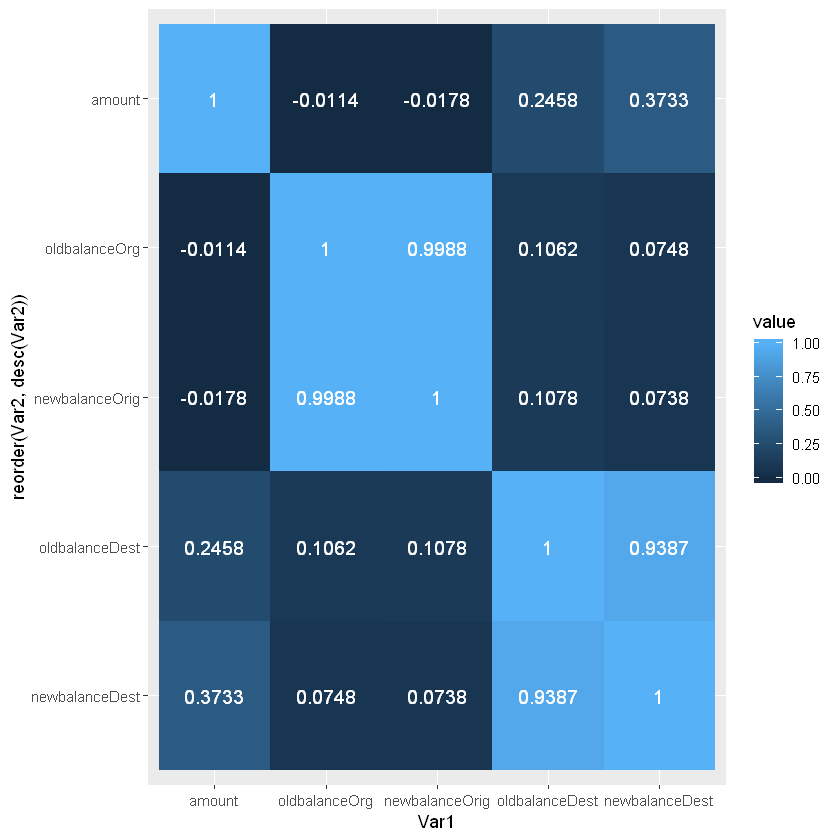

In [11]:
# Get correlations
cor_paysim <- round(cor(paysim[c("amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest")]),4)
melted_cor_paysim <- melt(cor_paysim)

ggplot(melted_cor_paysim, aes(x = Var1, y= reorder(Var2, desc(Var2)), fill = value)) + geom_tile() +
  #scale_fill_gradient2(low="black", high ="#F9EBDD") +
  geom_text(aes(Var1, Var2, label = value), color = "white", size = 4)

In [12]:
# Normalize
normalize2 <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

normvars <- vector()

normvars[c("normamount","normoldbalanceOrg","normnewbalanceOrig",
           "normoldbalanceDest","normnewbalanceDest")] <- lapply(paysim[c("amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest")], normalize2)

head(paysim)

paysim <- cbind(paysim, normvars)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,TRANSFER,PAYMENT,CASH_OUT,DEBIT,CASH_IN
3,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0,0.00,1,0,1,0,0,0,0
4,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182,0.00,1,0,0,0,1,0,0
8,1,PAYMENT,7861.64,C1912850431,176087.2,168225.59,M633326333,0,0.00,0,0,0,1,0,0,0
9,1,PAYMENT,4024.36,C1265012928,2671.0,0.00,M1176932104,0,0.00,0,0,0,1,0,0,0
10,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898,40348.79,0,0,0,0,0,1,0
11,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845,157982.12,0,0,0,0,0,1,0


In [13]:
# Prepare Data Sets
X2 <- paysim[c("normamount","normoldbalanceOrg","normnewbalanceOrig",
                         "normoldbalanceDest","normnewbalanceDest","PAYMENT",
                         "TRANSFER","CASH_OUT", "DEBIT", "CASH_IN", "isFraud")]

In [14]:
# K-folds Cross-Validation
set.seed(1234)
kf <- createFolds(X2$isFraud, k = 10)

In [15]:
# Running and Testing the Logistic Regression Model
cv = lapply(kf, function(x) {
  # Establishes the training and testing folds
  training_fold = X2[-x,]
  test_fold = X2[x,]
  # Constructing model
  model <- glm(isFraud ~. ,family = binomial, data=training_fold)
  pred <- round(predict(model, newdata = test_fold, type = "response"))
  accuracy = round(mean(1-abs(pred - test_fold$isFraud)),4)
  print(c("Accuracy: ",accuracy))
})

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

[1] "Accuracy: " "0.9988"    


Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

[1] "Accuracy: " "0.9992"    


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

[1] "Accuracy: " "0.9985"    


Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

[1] "Accuracy: " "0.9996"    


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

[1] "Accuracy: " "0.9991"    


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

[1] "Accuracy: " "0.9984"    


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

[1] "Accuracy: " "0.9989"    


Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

[1] "Accuracy: " "0.953"     


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

[1] "Accuracy: " "0.9986"    


Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "Accuracy: " "0.9993"    
